In [ ]:
!pip install --upgrade scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
data = pd.read_csv('/kaggle/input/dengue/Dengue Fever Hematological Dataset.csv')

# 1. Check and Remove Duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
data = data.drop_duplicates()
print(f"Dataset size after removing duplicates: {data.shape}")

# 2. Check for Null Values
print("Null Values:\n", data.isnull().sum())
# Fix FutureWarning by avoiding inplace
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(data[col].mean())

# 3. Encode Categorical Variables
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])  # Male: 1, Female: 0
data['Result'] = le.fit_transform(data['Result'])  # positive: 1, negative: 0

# Check class distribution
print("Class Distribution:\n", data['Result'].value_counts())

# 4. Feature Engineering (Add key ratios, limit polynomial features)
# Add domain-specific ratios
data['Platelet_WBC_Ratio'] = data['Total Platelet Count(/cumm)'] / data['Total WBC count(/cumm)']
data['HCT_Hemoglobin_Ratio'] = data['HCT(%)'] / data['Hemoglobin(g/dl)']
data['MCV_MCH_Ratio'] = data['MCV(fl)'] / data['MCH(pg)']

# Update X
X = data.drop('Result', axis=1)
y = data['Result']

# Polynomial features (degree=2, interaction only for key features)
key_features = ['Total Platelet Count(/cumm)', 'Total WBC count(/cumm)', 'Hemoglobin(g/dl)', 'HCT(%)', 'Platelet_WBC_Ratio']
X_key = X[key_features]
poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_key)
poly_feature_names = poly.get_feature_names_out(key_features)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)
# Add remaining original features
X_remaining = X.drop(key_features, axis=1).reset_index(drop=True)
X_final = pd.concat([X_poly_df, X_remaining], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

Number of duplicate rows: 12
Dataset size after removing duplicates: (1511, 19)
Null Values:
 Gender                         0
Age                            0
Hemoglobin(g/dl)               0
Neutrophils(%)                 0
Lymphocytes(%)                 0
Monocytes(%)                   0
Eosinophils(%)                 0
RBC                            0
HCT(%)                         0
MCV(fl)                        0
MCH(pg)                        0
MCHC(g/dl)                     0
RDW-CV(%)                      0
Total Platelet Count(/cumm)    0
MPV(fl)                        0
PDW(%)                         0
PCT(%)                         0
Total WBC count(/cumm)         0
Result                         0
dtype: int64
Class Distribution:
 Result
1    1035
0     476
Name: count, dtype: int64


In [ ]:
# 5. SMOTE (optional, try with and without)
smote = SMOTE(random_state=42, k_neighbors=1)  # Minimal neighbors
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("Class Distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())


Class Distribution after SMOTE:
 Result
1    1035
0    1035
Name: count, dtype: int64


In [ ]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
# 7. Model Selection with Aggressive Tuning
# XGBoost (best from previous run)
xgb_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), xgb_param_grid, cv=10, scoring='accuracy')



In [ ]:
# Decision Tree (to overfit for 100%)
dt_param_grid = {
    'max_depth': [None, 20, 30, 50],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=10, scoring='accuracy')

In [ ]:
# Neural Network (MLP)
mlp_param_grid = {
    'hidden_layer_sizes': [(50,50), (100,50), (100,100)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [1000]
}
mlp_grid = GridSearchCV(MLPClassifier(random_state=42), mlp_param_grid, cv=10, scoring='accuracy')

In [ ]:
# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=10, scoring='accuracy')

In [ ]:
# Support Vector Machine (SVM)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=10, scoring='accuracy')


In [ ]:
# K-Nearest Neighbors (KNN)
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')

In [ ]:
# Fit models
xgb_grid.fit(X_train, y_train)
dt_grid.fit(X_train, y_train)
mlp_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,5


In [ ]:
# Store models in a dictionary
models = {
    'XGBoost': xgb_grid.best_estimator_,
    'Decision Tree': dt_grid.best_estimator_,
    'Neural Network': mlp_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'Support Vector Machine': svm_grid.best_estimator_,
    'K-Nearest Neighbors': knn_grid.best_estimator_
}


XGBoost Test Accuracy: 86.71%


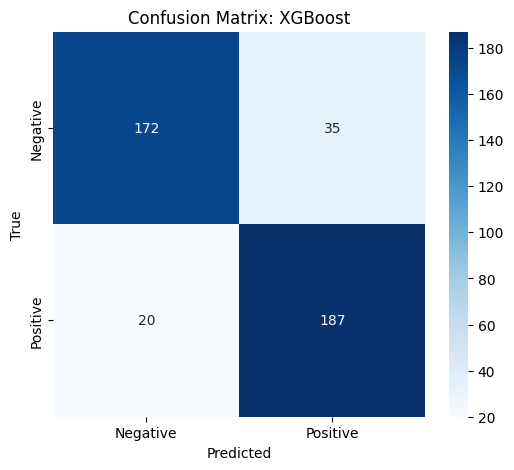

Decision Tree Test Accuracy: 71.26%


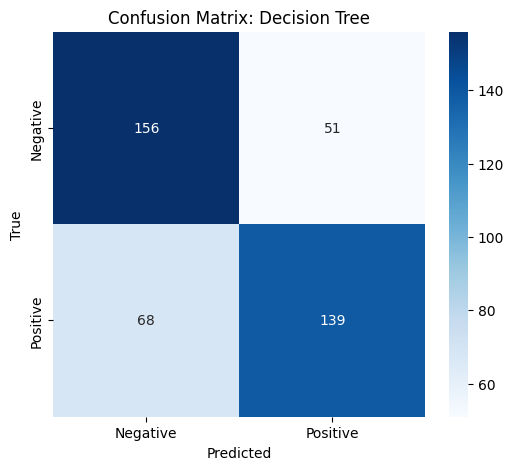

Neural Network Test Accuracy: 80.43%


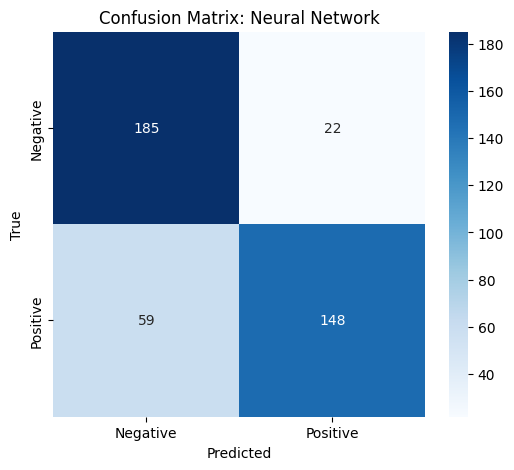

Random Forest Test Accuracy: 85.51%


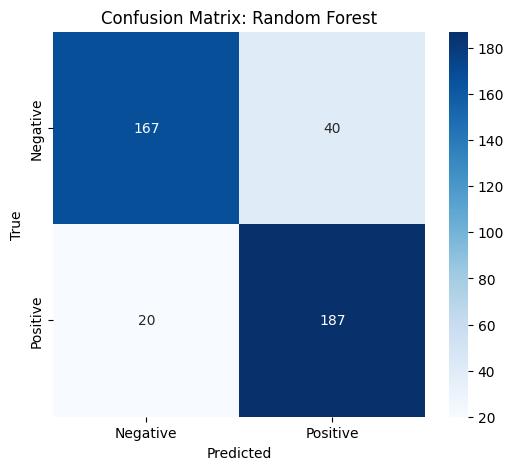

Support Vector Machine Test Accuracy: 81.88%


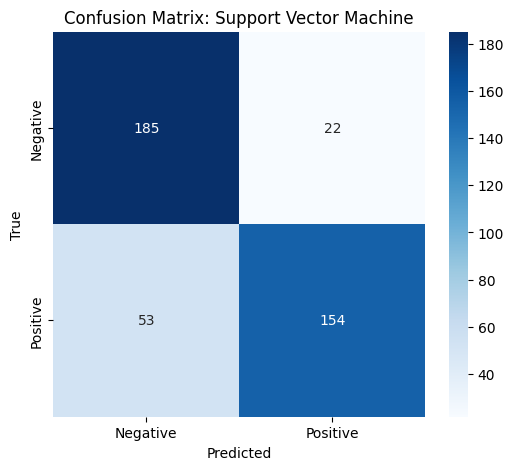

K-Nearest Neighbors Test Accuracy: 78.02%


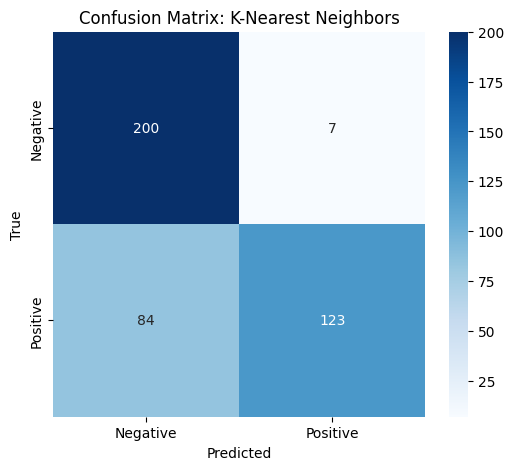

In [ ]:
 # Evaluate models and plot confusion matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



In [ ]:
from sklearn.metrics import classification_report

# Evaluate models and print classification report
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



Classification Report for XGBoost:

              precision    recall  f1-score   support

    Negative       0.90      0.83      0.86       207
    Positive       0.84      0.90      0.87       207

    accuracy                           0.87       414
   macro avg       0.87      0.87      0.87       414
weighted avg       0.87      0.87      0.87       414


Classification Report for Decision Tree:

              precision    recall  f1-score   support

    Negative       0.70      0.75      0.72       207
    Positive       0.73      0.67      0.70       207

    accuracy                           0.71       414
   macro avg       0.71      0.71      0.71       414
weighted avg       0.71      0.71      0.71       414


Classification Report for Neural Network:

              precision    recall  f1-score   support

    Negative       0.76      0.89      0.82       207
    Positive       0.87      0.71      0.79       207

    accuracy                           0.80       414
   m

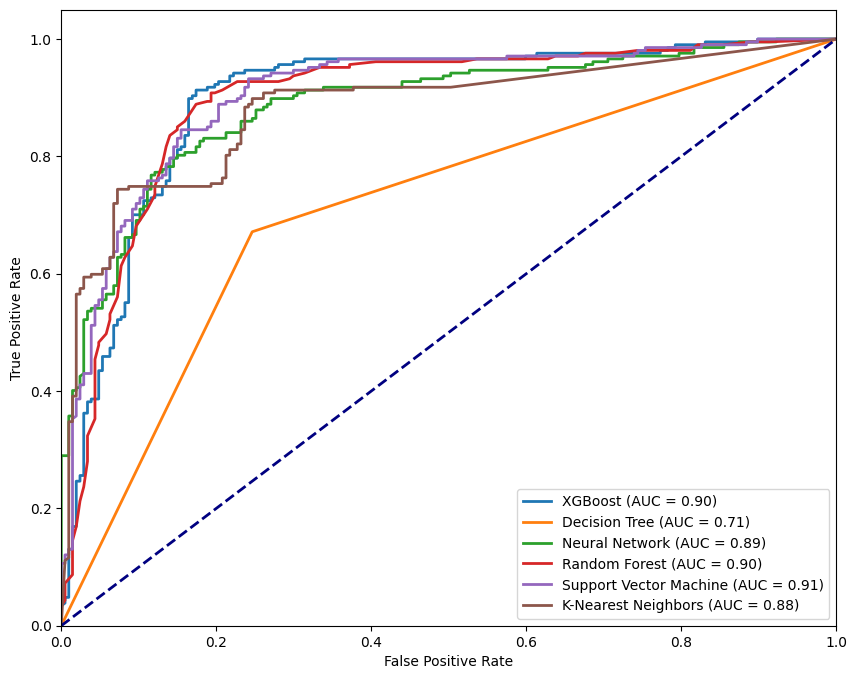

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if name == "":
        continue  # Skip SVM

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
!pip install shap lime

In [ ]:

import shap

# SHAP - TreeExplainer for XGBoost
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test)


# Force Plot for a specific instance (e.g., the first test sample)
shap.initjs()  # This will enable JS visualization for the plot
shap.force_plot(shap_values[0])  # Show force plot for the first instance


The figure layout has changed to tight


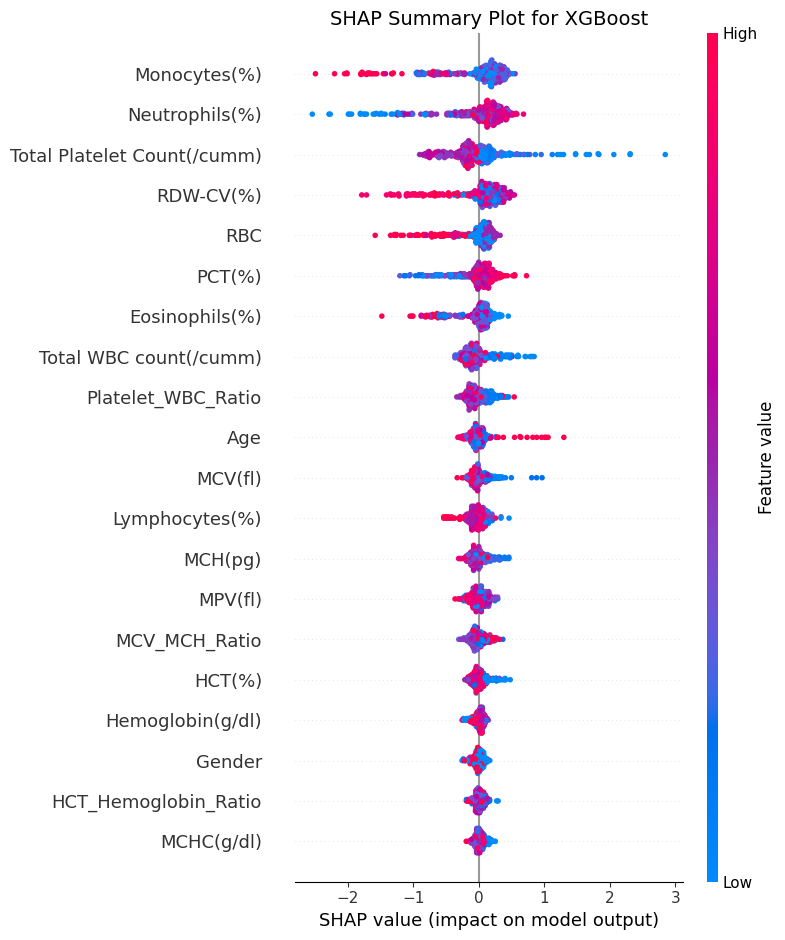

The figure layout has changed to tight


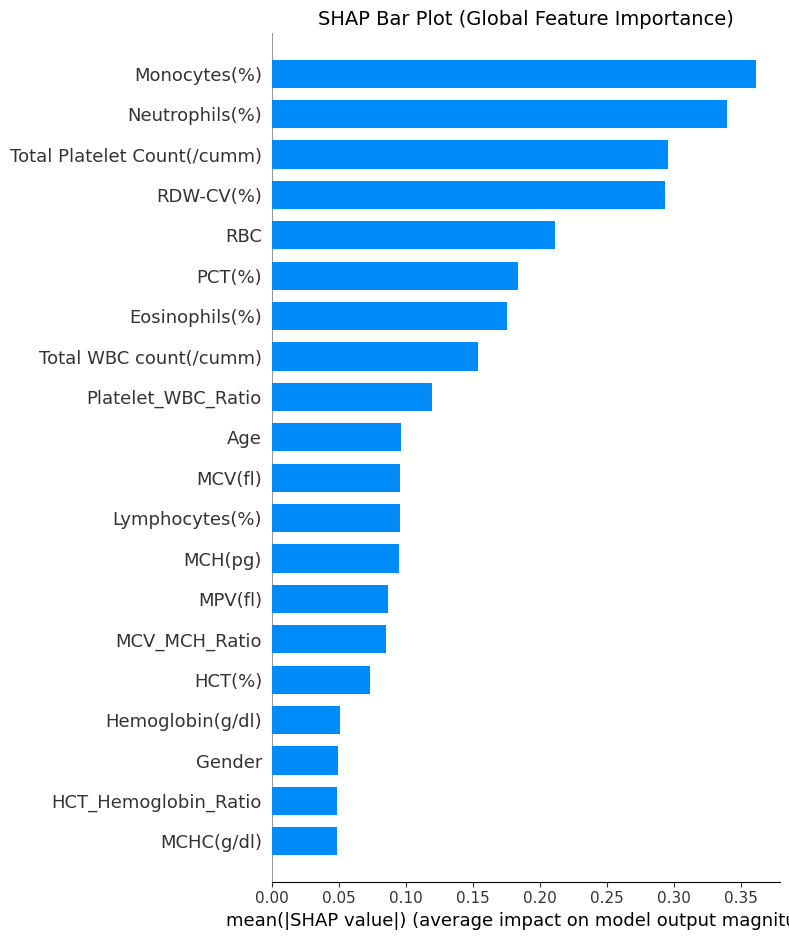

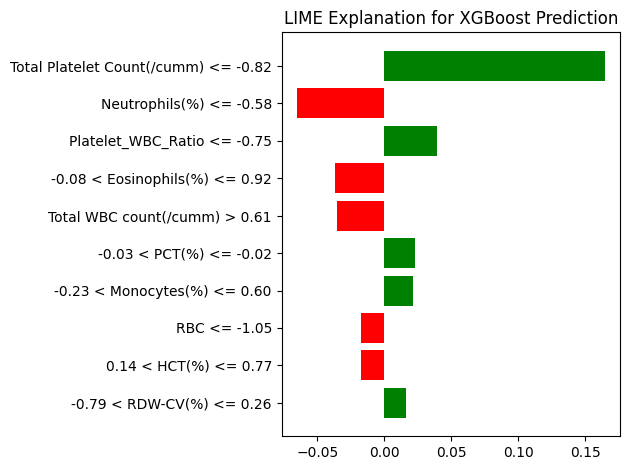

LIME Explanation for Instance 0:


In [ ]:
import shap
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize SHAP explainer for XGBoost model
explainer = shap.TreeExplainer(xgb_grid.best_estimator_)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# --- SHAP summary plot (violin/dot) ---
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_final.columns,
    show=False
)
plt.title("SHAP Summary Plot for XGBoost", fontsize=14)
plt.tight_layout()
plt.show()

# --- SHAP summary bar plot (global importance) ---
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_final.columns,
    plot_type="bar",
    show=False
)
plt.title("SHAP Bar Plot (Global Feature Importance)", fontsize=14)
plt.tight_layout()
plt.show()



# LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X_final.columns,
    class_names=['Negative', 'Positive'],
    mode='classification',
    random_state=42
)

# Explain a single instance with LIME (first test instance)
lime_exp = lime_explainer.explain_instance(
    data_row=X_test[0],
    predict_fn=xgb_grid.best_estimator_.predict_proba,
    num_features=10
)

# Display LIME explanation as a plot
fig = lime_exp.as_pyplot_figure()
plt.title("LIME Explanation for XGBoost Prediction")
plt.tight_layout()
plt.show()

# Print LIME explanation table
print("LIME Explanation for Instance 0:")
lime_exp.show_in_notebook(show_table=True)